- Register env with ray.tune.registery
- training config
- can access policy with Algorithm.get_policy()
- check evaluation options in config
- check checkpoint options in config
- for fast env small model PPO: increase num_env_runners, maybe eneable vectorization for inference
- check batch size

In [92]:
from rleplus.examples.registry import register_all
register_all()

In [93]:
import ray
from ray import air, tune
from ray.rllib.algorithms.ppo import PPOConfig

In [94]:
env_setup = {
    "env": "BBrightEnv",
    "csv": False,
    "verbose": False,
    "output": "./tmp/episodes/",
    "num_workers": 1,
    "num_gpus": 0,
    "alg": "PPO",
    "use-lstm": False
}


config = (
    PPOConfig()
    .environment(
        env=env_setup["env"],
        env_config=env_setup,
    )
    .framework("torch")
    .training(
        gamma=0.95,
        lr=0.03,
        kl_coeff=0.3,
        train_batch_size=96,
        sgd_minibatch_size=96,
        vf_loss_coeff=0.01,
        use_critic=True,
        use_gae=True,
        model={
            "use_lstm": True,
            "vf_share_layers": False,
        },
        _enable_learner_api=True,
    )
    .rl_module(_enable_rl_module_api=True)
    .framework(
        # to use tensorflow, you'll need install it first,
        # then set framework="tf2" and eager_tracing=True (for fast exec)
        framework="torch",
    )
    .resources(num_gpus=env_setup["num_gpus"])
    .rollouts(
        num_rollout_workers=env_setup["num_workers"],
        rollout_fragment_length="auto",
    )
    
)

In [95]:
ray.shutdown()

In [96]:
ray.init()

register_all()

algo = config.build()
results = []
for i in range(2):
    result = algo.train()
    results.append(result)

    if i % 24 == 0:
        checkpoint = algo.save()
        print("checkpoint saved at", checkpoint)

ray.shutdown()

/home/l4/.cache/pypoetry/virtualenvs/rl-energyplus-hi-YszVVEjS-py3.10/lib/python3.10/site-packages/ray/_private/node.py:1308: ResourceWarning: unclosed file <_io.TextIOWrapper name='/tmp/ray/session_2024-08-10_01-10-17_274491_35277/logs/gcs_server.out' mode='a' encoding='utf-8'>
  self.start_gcs_server()
/home/l4/.cache/pypoetry/virtualenvs/rl-energyplus-hi-YszVVEjS-py3.10/lib/python3.10/site-packages/ray/_private/node.py:1308: ResourceWarning: unclosed file <_io.TextIOWrapper name='/tmp/ray/session_2024-08-10_01-10-17_274491_35277/logs/gcs_server.err' mode='a' encoding='utf-8'>
  self.start_gcs_server()
/home/l4/.cache/pypoetry/virtualenvs/rl-energyplus-hi-YszVVEjS-py3.10/lib/python3.10/site-packages/ray/_private/node.py:1313: ResourceWarning: unclosed file <_io.TextIOWrapper name='/tmp/ray/session_2024-08-10_01-10-17_274491_35277/logs/monitor.out' mode='a' encoding='utf-8'>
  self.start_monitor()
/home/l4/.cache/pypoetry/virtualenvs/rl-energyplus-hi-YszVVEjS-py3.10/lib/python3.10/sit

(RolloutWorker pid=72185) Episode: -1  finised at Timestep: 0
(RolloutWorker pid=72185) Episode: 0  finised at Timestep: 0


2024-08-10 01:10:30,126	WARNING util.py:62 -- Install gputil for GPU system monitoring.
/tmp/ipykernel_35277/1101895335.py:5: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/l4/ray_results/PPO_BBrightEnv_2024-08-10_01-06-43b9l197w6/progress.csv' mode='a' encoding='UTF-8'>
  algo = config.build()
/tmp/ipykernel_35277/1101895335.py:5: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/l4/ray_results/PPO_BBrightEnv_2024-08-10_01-06-43b9l197w6/result.json' mode='a' encoding='UTF-8'>
  algo = config.build()


(RolloutWorker pid=72185) Episode: 1  finised at Timestep: 1
(RolloutWorker pid=72185) History saved to ./tmp/history.pkl at timestep 96
(RolloutWorker pid=72185) Episode: 2  finised at Timestep: 96
checkpoint saved at TrainingResult(checkpoint=Checkpoint(filesystem=local, path=/tmp/tmpptnv14vw), metrics={'custom_metrics': {}, 'episode_media': {}, 'info': {'learner': {'__all__': {'num_agent_steps_trained': 1536.0, 'num_env_steps_trained': 96.0, 'total_loss': 7844.734955847263}, 'default_policy': {'total_loss': 7844.734955847263, 'policy_loss': 0.40833766758441925, 'vf_loss': 9.806695938110352, 'vf_loss_unclipped': 2058.9841918945312, 'vf_explained_var': 0.029399961233139038, 'entropy': -0.1137886643409729, 'mean_kl_loss': 26147.427734375, 'default_optimizer_lr': 0.03, 'curr_lr': 0.03, 'curr_entropy_coeff': 0.0, 'curr_kl_coeff': 0.45000001788139343}}, 'num_env_steps_sampled': 96, 'num_env_steps_trained': 0, 'num_agent_steps_sampled': 96, 'num_agent_steps_trained': 0}, 'sampler_results':

/usr/lib/python3.10/subprocess.py:1072: ResourceWarning: subprocess 71606 is still running
  _warn("subprocess %s is still running" % self.pid,


In [97]:
print(results[-1].keys())
print(results[-1]["info"].keys())
print(results[-1]["info"]["learner"].keys())
print(results[-1]["info"]["learner"]["default_policy"].keys())
print(results[-1]["info"]["learner"]["default_policy"])

dict_keys(['custom_metrics', 'episode_media', 'info', 'sampler_results', 'episode_reward_max', 'episode_reward_min', 'episode_reward_mean', 'episode_len_mean', 'episodes_this_iter', 'policy_reward_min', 'policy_reward_max', 'policy_reward_mean', 'hist_stats', 'sampler_perf', 'num_faulty_episodes', 'connector_metrics', 'num_healthy_workers', 'num_in_flight_async_reqs', 'num_remote_worker_restarts', 'num_agent_steps_sampled', 'num_agent_steps_trained', 'num_env_steps_sampled', 'num_env_steps_trained', 'num_env_steps_sampled_this_iter', 'num_env_steps_trained_this_iter', 'num_env_steps_sampled_throughput_per_sec', 'num_env_steps_trained_throughput_per_sec', 'timesteps_total', 'num_steps_trained_this_iter', 'agent_timesteps_total', 'timers', 'counters', 'done', 'episodes_total', 'training_iteration', 'trial_id', 'date', 'timestamp', 'time_this_iter_s', 'time_total_s', 'pid', 'hostname', 'node_ip', 'config', 'time_since_restore', 'iterations_since_restore', 'perf'])
dict_keys(['learner', 'n

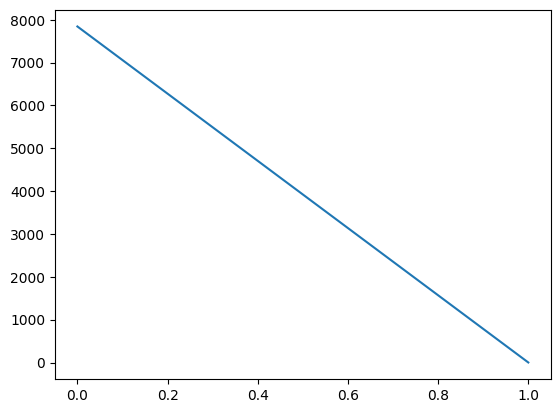

In [98]:
# plot loss over time
import matplotlib.pyplot as plt
plt.plot([r["info"]["learner"]["default_policy"]['total_loss'] for r in results])
plt.show()

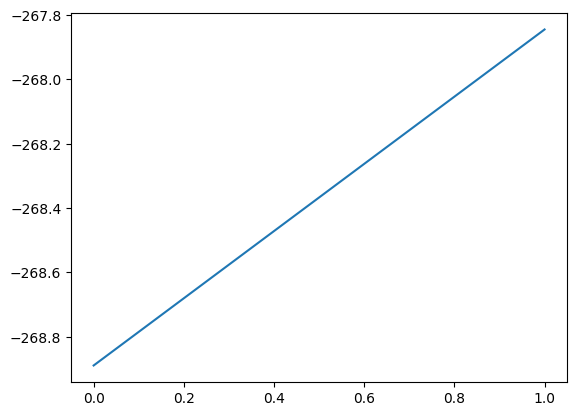

In [99]:
# plot mean reward over each episode
plt.plot([r['episode_reward_mean'] for r in results])
plt.show()

In [104]:
# read the result pickle file
import pickle as pkl

episode_results = []
# Read the history from the pickle
with open('./tmp/history.pkl', 'rb') as f:
    while True:
        try:
            episode_results.append(pkl.load(f))
        except EOFError:
            break

print(episode_results[0].keys())
print(len(episode_results))

# combine the results of each episode
import numpy as np

combined_results = {}
for k in episode_results[0].keys():
    combined_results[k] = np.concatenate([r[k] for r in episode_results])

print(combined_results.keys())
print(len(combined_results['reward']))

dict_keys(['out_tmp', 'air_tmp', 'opr_tmp', 'air_hum', 'htg_stp', 'clg_stp', 'eeq_htg', 'air_chg', 'rad_tmp', 'reward'])
2
dict_keys(['out_tmp', 'air_tmp', 'opr_tmp', 'air_hum', 'htg_stp', 'clg_stp', 'eeq_htg', 'air_chg', 'rad_tmp', 'reward'])
191
